# Individual based modelling

Support for modelling alive or active particles, whose properties/state change in time, is being developed. At the current time, only support for modelling particle *mortality* is included. Examples describing how to include these processes in lagrangian experiments are given below. To ensure the workflow is clean and easy to follow, the examples are run in isolation using a sample particle set. Transport processes are not included. However, the same processes can be easily included when doing transport modelling.
Configuration options are specified in the run config file under the secion `BIO_MODEL`.

<div class="alert alert-info">

**Note:**
    
Where appropriate, the term *individual* will be used to describe particles that are alive. 

</div>

## Mortality

PyLag includes an abstract base class called `MortalityCalculator`. New mortality calculators can be added to the model by subclassing `MortalityCalculator`. At the current time, the model includes the following mortality calculators:

1. **FixedTimeMortalityCalculator** - individuals are killed after a fixed, specified period of time.

2. **ProbabilisticMortalityCalculator** - individuals are killed probabilistically, governed by a specific rate.

Below we demonstrate how both of these can be used to control individual mortality. To begin, we do some initial setup work that is common to each example.

In [1]:
# Imports
import numpy as np
from matplotlib import pyplot as plt
from configparser import ConfigParser

import pylag.random as random
from pylag.data_reader import DataReader
from pylag.particle_cpp_wrapper import ParticleSmartPtr
from pylag.mortality import get_mortality_calculator
from pylag.processing.plot import create_figure

# Parameters
seconds_per_day = 86400.

# Seed the random number generator
random.seed(10)

# Create the config
config = ConfigParser()
config.add_section('NUMERICS')
config.add_section('BIO_MODEL')
config.add_section('FIXED_TIME_MORTALITY_CALCULATOR')
config.add_section('PROBABILISTIC_MORTALITY_CALCULATOR')

# We need a data reader to pass to the mortality calculator. It
# can be used to draw out environmental variables (e.g. temperature)
# that affect mortality. In both cases below, it isn't used, so we
# use the base class.
data_reader = DataReader()

# Set time stepping params
simulation_duration_in_days = 20.0
time_step = 100
time_end = simulation_duration_in_days * seconds_per_day
times = np.arange(0.0, time_end, time_step)

# Helper function in which the model is run and mortality computed
def run(config, n_particles=1000):
    """ Run the model to compute mortality through time """
    
    # Create the mortality calculator
    mortality_calculator = get_mortality_calculator(config)

    # Create the living particle seed
    particle_set = []
    for i in range(n_particles):
        # Instantiate a new particle
        particle = ParticleSmartPtr(age=0.0, is_alive=True)
        
        # Initialise particle mortality parameters
        mortality_calculator.set_initial_particle_properties_wrapper(particle)
        
        # Append it to the particle set
        particle_set.append(particle)

    # Store the number of living particles in a list
    n_alive_arr = []

    # Run the model
    n_alive = n_particles
    for t in times:
        n_alive_arr.append(n_alive)

        n_deaths = 0
        for particle in particle_set:
            if particle.is_alive:
                mortality_calculator.apply_wrapper(data_reader, t, particle)
                if particle.is_alive == False:
                    n_deaths += 1
            particle.set_age(t)

        n_alive -= n_deaths

    return n_alive_arr


### FixedTimeMortalityCalculator

The use of a `FIXED_TIME_MORTALITY_CALCULATOR` is speficied by setting the option `mortality_calculator` to `fixed_time` in the section `BIO_MODEL` in the run configuration file. The mortality calculator kills particles after they reach a given age. The age at which particles die can be set in one of three different ways. The choice is made through the option `initialisation_method` in the section `FIXED_TIME_MORTALITY_CALCUATOR` in the run configuration file. The choices are:

1. **common_value**: It is set to a fixed, common value which is the same for all particles.
2. **uniform_random**: It is set to a value drawn from a uniform random distribution with specified limits.
3. **gaussian_random**: It is set to a value drawn from a normal distribution with specified mean and standard deviation.

All values are given in days. The use of each option is demonstrated below. In the demonstration, we create a population of $1000$ individuals. In the **common_value** scenario, all particles are killed once they reach an age, $t_{\mathrm{age}}$, of 10 days. In the **uniform_random** scenario, the age of death is drawn from a uniform random distribution with $t_{\mathrm{age}} \in [8, 12]$ days. In the **gaussian_random** scenario, $t_{\mathrm{age}}$ is drawn from a normal distribution with a mean and standard deviation of 10 and 1 days respectively.   

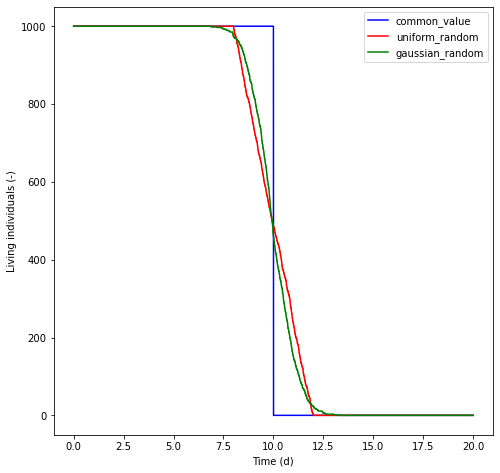

In [2]:
# Specify a fixed time mortality calculator
config.set('BIO_MODEL', 'mortality_calculator', 'fixed_time')

# 1) Fixed time scenario
age_of_death_in_days = 10.
config.set('FIXED_TIME_MORTALITY_CALCULATOR', 'initialisation_method', 'common_value')
config.set('FIXED_TIME_MORTALITY_CALCULATOR', 'common_value', str(age_of_death_in_days))
n_alive_common_value = run(config)
           
# 2) Uniform random
minimum_bound = 8.
maximum_bound = 12.
config.set('FIXED_TIME_MORTALITY_CALCULATOR', 'initialisation_method', 'uniform_random')
config.set('FIXED_TIME_MORTALITY_CALCULATOR', 'minimum_bound', str(minimum_bound))
config.set('FIXED_TIME_MORTALITY_CALCULATOR', 'maximum_bound', str(maximum_bound))
n_alive_uniform_random = run(config)

# 2) Gaussian random
mean = 10.
standard_deviation = 1.
config.set('FIXED_TIME_MORTALITY_CALCULATOR', 'initialisation_method', 'gaussian_random')
config.set('FIXED_TIME_MORTALITY_CALCULATOR', 'mean', str(mean))
config.set('FIXED_TIME_MORTALITY_CALCULATOR', 'standard_deviation', str(standard_deviation))
n_alive_gaussian_random = run(config)

# Set the bio time step
config.set('NUMERICS', 'bio_time_step', str(time_step))
    
    
# Plot
font_size = 10
fig, ax = create_figure(figure_size=(20, 20), font_size=font_size)
plt.plot(times/seconds_per_day, n_alive_common_value, 'b', label='common_value')
plt.plot(times/seconds_per_day, n_alive_uniform_random, 'r', label='uniform_random')
plt.plot(times/seconds_per_day, n_alive_gaussian_random, 'g', label='gaussian_random')
plt.ylabel('Living individuals (-)', fontsize=font_size)
plt.xlabel('Time (d)', fontsize=font_size)

# Add legend
plt.legend()

### ProabilisticMortalityCalculator

The mortality calculator kills particles at a rate $\mu_{D} \Delta t$, where $\mu_{D}$ is a fixed mortality rate which is set in the run configuraiton file and $\Delta t$ is the model time step for biological processes. The model computes a uniform random deviate in the range (0, 1). If the number is less than the computed death rate, the particle is killed. Below, we create a population of $1000$ individuals. We apply a death rate of $0.1$ per day and use a time step of $100$ seconds. The model is run forward for $20$ days and the number of living individuals plotted as a function of time. The result is compared with a simple analytical solution of exponential decay.

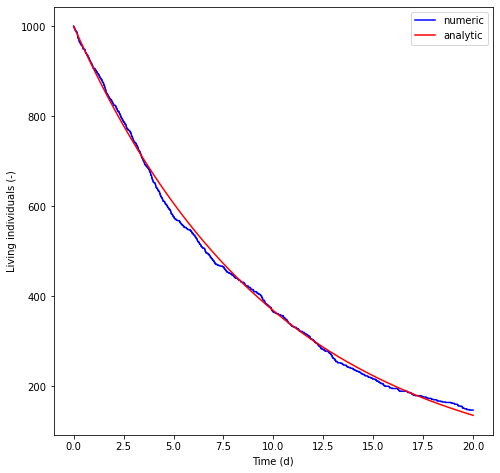

In [6]:
# Specify a probabilistic mortality calculator
config.set('BIO_MODEL', 'mortality_calculator', 'probabilistic')

# Set the death rate - currently the same for all particles.
death_rate_per_day = 0.1
config.set('PROBABILISTIC_MORTALITY_CALCULATOR', 'death_rate_per_day', str(death_rate_per_day))

# Set the bio time step
config.set('NUMERICS', 'bio_time_step', str(time_step))

# Number of particles
n_particles = 1000

# Run the model
n_alive_numeric = run(config, n_particles=n_particles)

# Compute the equivalen analytical solution
death_rate_per_second = death_rate_per_day / seconds_per_day
n_alive_analytic = n_particles * np.exp(-death_rate_per_second * times)

# Plot
font_size = 10
fig, ax = create_figure(figure_size=(20, 20), font_size=font_size)
plt.plot(times/seconds_per_day, n_alive_numeric, 'b', label='numeric')
plt.ylabel('Living individuals (-)', fontsize=font_size)
plt.xlabel('Time (d)', fontsize=font_size)

# Add equivalent analytical solution
plt.plot(times/seconds_per_day, n_alive_analytic, 'r', label='analytic')

# Add legend
plt.legend()